In [11]:
pip install qiskit numpy pylatexenc

  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=aa9ef46311feaa8d3cbe4f0ab427a6b1712ce8302b88d455f18532be639817ce
  Stored in directory: /Users/oneman/Library/Caches/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
Note: you may need to restart the kernel to use updated packages.


In [8]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.quantum_info import Statevector, Operator
#from qiskit.circuit.library import AndGate
#from qiskit.circuit.library import MCXGate

import numpy as np
import SudoquCircuitBuilder as sudoqu
import PuzzleConfigurations as pc

# Summary of the algorithm:

Step 1: input a $2^2\times 2^2$ Sudoku board

Step 2: prepare input for quantum circuit initialization:
    - Find all possible configurations for each row, each column, and each $2\times 2$-quadrant of the given board. If a row/column/quadrant trivially only has one possible configuration, we immediately fill the unknows with that configuration. 
    - The number of rows + columns + quadrants is $4+4+4=12$. This is the maximal number of constraints we will have. In practice, not all will be present. Each row/column/quadrant has to take on one of the possible configurations we have found in the previous step. 

Steo 3: Initialize qubits:
    - If $n$ is the number of unknowns left, then we need $n\times 2$ qubits to represent the unkowns. We initialize them as $H\ket{00}$.
    - For each constraint, we will need one ancillar qubit, which tells us if that constraint is satisfied or not.

Step 4: #todo




We begin by inputting the entries of a $2^2\times 2^2$ Sudoku game. Our convention will be to indicate unknown values by $0.$ All other values must be 1, 2, 3, 4.

In [ ]:
#todo: code that reads in a sudoky board

Now we will find all configurations for rows/columns/quadrants and complete the values which can be trivially filled.

In [2]:
puzzle = [
        [3, 1, 4, 2],
        [2, 0, 0, 1],
        [1, 0, 0, 0],
        [4, 0, 0, 3]
    ] #todo: this runs a predefined sudoku. Need to change that to plugging in the one read in above

print("Started with the following puzzle:")
for row in puzzle:
    print(row)
print()

pc.complete_all_trivial_missing_values(puzzle)

print("Completed trivial missing values. Current puzzle:")
for row in puzzle:
    print(row)
print()

# count remaining unknowns
number_of_unknowns = 0
for row in puzzle:
    number_of_unknowns += row.count(0)

print("Number of remaining unknowns:", number_of_unknowns)

# count remaining constraints
number_of_constraints = 0
#count row constraints
for row in puzzle:
    if row.count(0)!= 0:
        number_of_constraints += 1
# count column constraints
for col in [[puzzle[r][group_index] for r in range(4)] for group_index in range(4)]:
    if col.count(0) != 0:
        number_of_constraints += 1
# count square constraints
for square_row_index in range(2):
    for square_col_index in range(2):
        current_square_indices = [
            (r, c)
            for r in range(2 * square_row_index, 2 * square_row_index + 2)
            for c in range(2 * square_col_index, 2 * square_col_index + 2)
        ]

        current_square_values = [
            puzzle[r][c] for (r, c) in current_square_indices
        ]
        if current_square_values.count(0) != 0:
            number_of_constraints += 1

print("Number of remaining constraints:", number_of_constraints)

Started with the following puzzle:
[3, 1, 4, 2]
[2, 0, 0, 1]
[1, 0, 0, 0]
[4, 0, 0, 3]

Completed trivial missing values. Current puzzle:
[3, 1, 4, 2]
[2, 4, 3, 1]
[1, 0, 0, 4]
[4, 0, 0, 3]

Number of remaining unknowns: 4
Number of remaining constraints: 6


Our next step is to initiate our qubits and a circuit. Let $n$ be the number of unknowns on the board after completing obvous unknowns. To represent the four numbers 1, 2, 3, 4 we will need 2 bits. Each bit we can then represent via a quibit in the obvious way: $0\mapsto \ket{0}$ and $1\mapsto \ket{1}$. Thus we need two qubits to represent the four numbers 1, 2, 3, 4 via qubits. Hence, we initiate $n\times 2$ qubits for the unknowns. 

Notation: We will use the number $0$ to represent an unknown on the board. To save space, we will then represent the numbers 1, 2, 3, 4 as follows via bits: $$1\mapsto 00,$$
$$2\mapsto 01,$$
$$3\mapsto 10,$$ 
$$4\mapsto 11.$$

Notation: Let $i$ be an integer from $0$ to $n-1$. We denote by u_i the qubit corresponding to the zeroth bit of the $i$-th unknown and by t_i the first bit of the $i$-th unknown. For example, if the $7$-th unknown ends up being 3, we represent it with the bits $10$ and thus u_7=0 and t_7=1.

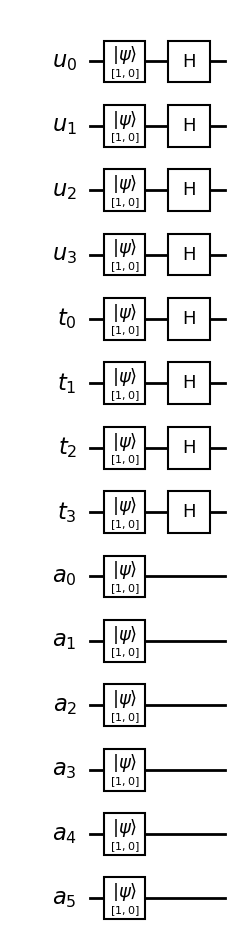

In [15]:
quantum_register_u = QuantumRegister(size=number_of_unknowns, name="u") #first bit of each unknown
quantum_register_t = QuantumRegister(size=number_of_unknowns, name="t") #second bit of each unknown
ancilla_register = AncillaRegister(size=number_of_constraints, name="a") #ancilla bits for the sudoku constraints

quantum_circuit = QuantumCircuit(quantum_register_u, quantum_register_t, ancilla_register, name="sudoqu") 

#initialize the unknowns as H|0>
for i in range(number_of_unknowns):
    quantum_circuit.initialize([1, 0], quantum_register_u[i])
    quantum_circuit.initialize([1, 0], quantum_register_t[i])
for i in range(number_of_unknowns):
    quantum_circuit.h(quantum_register_u[i])
    quantum_circuit.h(quantum_register_t[i])
#initialize the ancilla bits to |0>
for i in range(number_of_constraints):
    quantum_circuit.initialize([1, 0], ancilla_register[i])

# draw the initial circuit
quantum_circuit.draw(output="mpl", style="bw")


We will now need to add gates to check if the given qubits satisfy valid configurations for each row/column/quadrant.

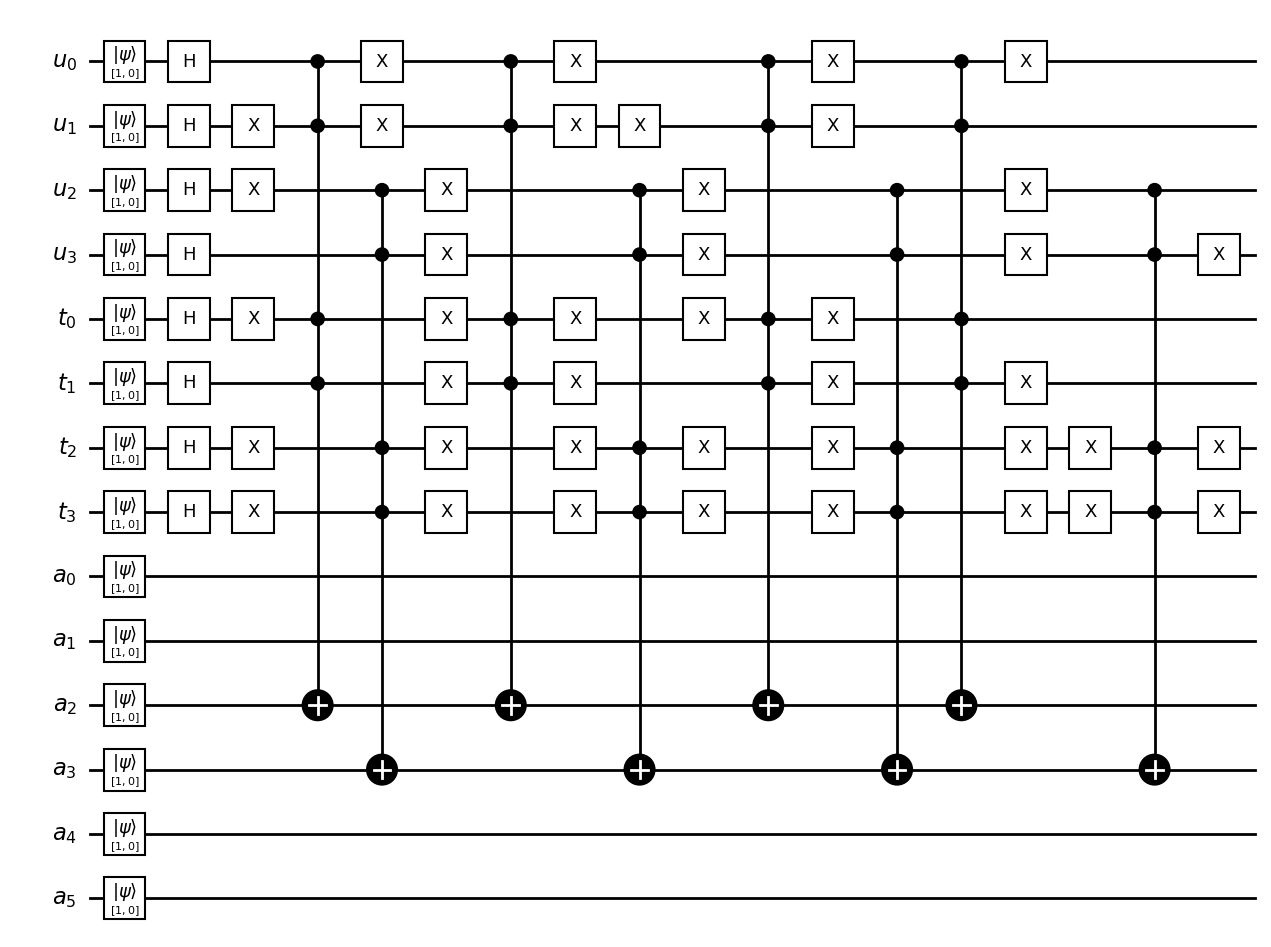

In [18]:
#need to do: start with row constraints. Load possible configurations for a given row. Check that the corresponding qubits satisfy the first configuration, or the second, or... and then this should be exported in the corresponding ancilla qubit

#create a dictionary to map numbers to bit values as described above
number_to_bit = {
    1: "00",
    2: "01",
    3: "10",
    4: "11"
}

#create a dictionary to map cell positions to 2-qubit indices
c_to_q = {}
for row in range(len(puzzle)):
    for col in range(len(puzzle[row])): 
        if puzzle[row][col] == 0:
            c_to_q[(row, col)] = len(c_to_q)

#create the row constraints
for row_index, (cell_positions, possible_configurations) in enumerate(pc.row_possible_values(puzzle)):
        if len(cell_positions) == 0:
            continue

        row_qubit_indices = [c_to_q[cell] for cell in cell_positions]
        
        for config in possible_configurations:
            #negate qubits which correspond to zeros in the bit string of confuguration
            for i in range(len(row_qubit_indices)):
                if config[i] == 1:
                    quantum_circuit.x(quantum_register_u[row_qubit_indices[i]])
                    quantum_circuit.x(quantum_register_t[row_qubit_indices[i]])
                if config[i] == 2:
                    quantum_circuit.x(quantum_register_t[row_qubit_indices[i]])
                if config[i] == 3:
                    quantum_circuit.x(quantum_register_u[row_qubit_indices[i]])
                    
            #apply and gate to given indices with result qubit in ancilla register
            quantum_circuit.mcx( 
                [quantum_register_u[row_qubit_indices[i]] for i in range(len(row_qubit_indices))] + 
                [quantum_register_t[row_qubit_indices[i]] for i in range(len(row_qubit_indices))],
                ancilla_register[row_index])

            #negate back qubits which correspond to zeros in the bit string of confuguration
            for i in range(len(row_qubit_indices)):
                if config[i] == 1:
                    quantum_circuit.x(quantum_register_u[row_qubit_indices[i]])
                    quantum_circuit.x(quantum_register_t[row_qubit_indices[i]])
                if config[i] == 2:
                    quantum_circuit.x(quantum_register_t[row_qubit_indices[i]])
                if config[i] == 3:
                    quantum_circuit.x(quantum_register_u[row_qubit_indices[i]])

#create the column constraints
#todo

#create the square constraints
#todo

# draw the circuit after adding the row constraints
quantum_circuit.draw(output="mpl", style="bw")

In [ ]:
#todo:implement andgate and orgate